In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizerFast

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import load_dataset

# Tải dữ liệu CoNLL-2003
dataset = load_dataset("conll2003")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [5]:
len(dataset["train"])

14041

In [6]:
label_list = dataset["train"].features["ner_tags"].feature.names
label_map = {label: idx for idx, label in enumerate(label_list)}

In [7]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

def tokenize_and_align_labels(batch):
    tokenized = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True, padding="max_length", max_length=128)
    labels = []
    for i, label in enumerate(batch["ner_tags"]):
        word_ids = tokenized.word_ids(i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(0)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(0)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized["labels"] = labels
    return tokenized

encoded_dataset = dataset.map(tokenize_and_align_labels, batched=True)
encoded_dataset.set_format(type="torch", columns=["input_ids", "labels"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [8]:
encoded_dataset["train"][1]

{'input_ids': tensor([  101,  2848, 13934,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [18]:
batch_size = 4
train_dataloader = DataLoader(encoded_dataset["train"], batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(encoded_dataset["validation"], batch_size = batch_size)
test_dataloader = DataLoader(encoded_dataset["test"], batch_size = batch_size)

In [10]:
len(train_dataloader)

1756

In [17]:
class RNN_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, seq_len, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, num_layers=4, hidden_size = hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        output, hidden = self.rnn(embedded)  # [batch_size, seq_len, hidden_dim]
        output = self.fc1(output)
        output = torch.relu(output)
        logits = self.fc2(output)     #[batch_size, seq_len, 9]
        return logits

In [12]:
from IPython.display import clear_output
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, criterion, num_epochs, lr):
    fig, ax = plt.subplots(1,1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    mean_losses = []
    losses = []
    for epoch in range(num_epochs):
        mean_loss = 0
        total_loss = 0
        for inputs in train_loader:
            input = inputs['input_ids']
            label = inputs['labels']
            label = label.view(-1)

            optimizer.zero_grad()
            outputs = model(input)
            outputs = outputs.view(-1, outputs.shape[-1])
            loss = criterion(outputs, label)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            total_loss += loss.item()

            clear_output(wait=True)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        mean_loss = total_loss/len(train_loader)
        mean_losses.append(mean_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, mean_loss_batch: {mean_loss:.4f}")

        ax.clear()
        ax.plot(mean_losses, label='Training Loss')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')
        ax.set_title('Training Loss')
        fig.canvas.draw()
        fig.canvas.flush_events()
    return model


In [13]:
train_dataloader.dataset["input_ids"].shape[1]

128

Epoch [5/5], Loss: 0.0788
Epoch 5/5, mean_loss_batch: 0.0245


RNN_NER(
  (embedding): Embedding(30522, 40, padding_idx=0)
  (rnn): RNN(40, 50, num_layers=4, batch_first=True)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=9, bias=True)
)

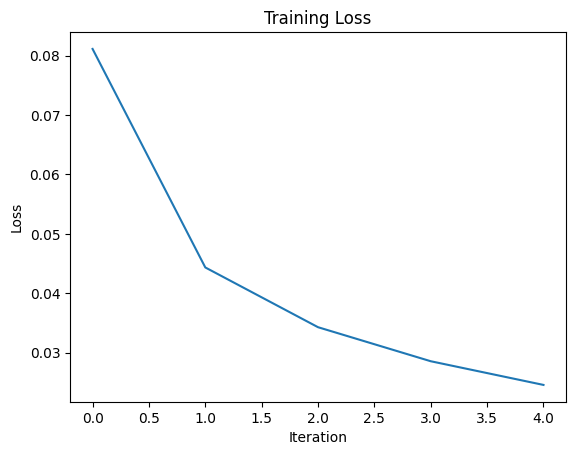

In [19]:
vocab_size = tokenizer.vocab_size
sequense_len = train_dataloader.dataset["input_ids"].shape[1]
embedding_dim = 40
hidden_dim = 50
hidden_layer =  512
output_dim = len(label_list)
pad_idx = tokenizer.pad_token_id

RNN_for_NER = RNN_NER(vocab_size, embedding_dim, hidden_dim, output_dim, sequense_len, pad_idx)

train(RNN_for_NER, train_dataloader, criterion, 5, 0.001)

In [83]:
train_dataloader.dataset["labels"][0]

tensor([0, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [43]:
dataset["train"]["tokens"][1]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [44]:
dataset["train"]["ner_tags"][0]

[3, 0, 7, 0, 0, 0, 7, 0, 0]

In [103]:
output = RNN_for_NER(train_dataloader.dataset["input_ids"][0])
output

tensor([[ 1.6883, -1.7821, -0.0574,  ..., -2.2590, -0.7420,  0.4344],
        [ 0.4598,  1.6076, -4.7975,  ..., -6.7445,  0.2599, -6.6151],
        [ 3.4901, -2.6585, -0.0248,  ..., -1.7630, -3.5287, -0.5534],
        ...,
        [ 4.1966, -2.1704, -3.6200,  ..., -3.3197, -1.8476, -3.1643],
        [ 4.1966, -2.1704, -3.6200,  ..., -3.3197, -1.8476, -3.1643],
        [ 4.1966, -2.1704, -3.6200,  ..., -3.3197, -1.8476, -3.1643]],
       grad_fn=<AddmmBackward0>)

In [20]:
def acunacy(model, Test_set):
  n = len(Test_set.dataset)*128
  correct = 0
  for data in Test_set.dataset:
    input_data = data["input_ids"]
    label = data["labels"]
    output = model(input_data)

    correct += torch.sum(torch.argmax(output, dim=1) == label).item()
  return correct/n


In [21]:
acunacy(RNN_for_NER, test_dataloader)

0.9895855958586737